In [94]:
import numpy as np
from qiskit import QuantumCircuit, transpile
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit
from qiskit.quantum_info import Kraus, SuperOp
from qiskit_aer import AerSimulator
from qiskit.tools.visualization import plot_histogram
from qiskit_aer.noise import (NoiseModel, QuantumError, ReadoutError,
    pauli_error, depolarizing_error, thermal_relaxation_error)

import matplotlib.pyplot as plt

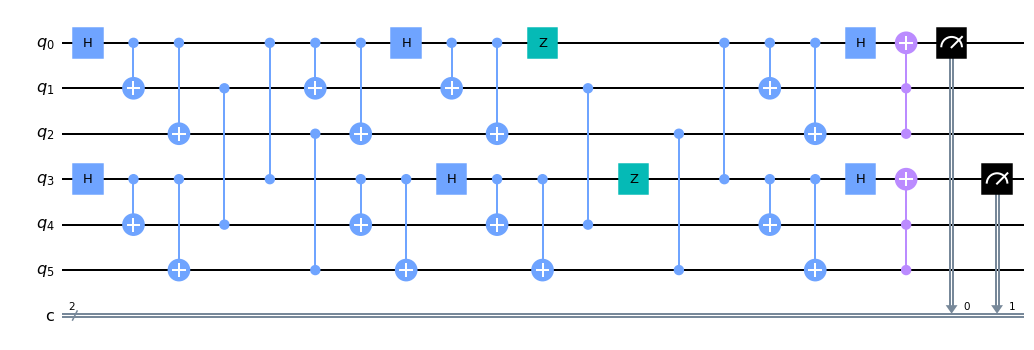

In [95]:
# Simplified version of error correction on grover's

qreg_q = QuantumRegister(6, 'q')
creg_c = ClassicalRegister(2, 'c')
s_circuit = QuantumCircuit(qreg_q, creg_c)

s_circuit.h(qreg_q[0])
s_circuit.h(qreg_q[3])
s_circuit.cx(qreg_q[0], qreg_q[1])
s_circuit.cx(qreg_q[3], qreg_q[4])
s_circuit.cx(qreg_q[0], qreg_q[2])
s_circuit.cx(qreg_q[3], qreg_q[5])
s_circuit.cz(qreg_q[0], qreg_q[3])
s_circuit.cz(qreg_q[1], qreg_q[4])
s_circuit.cz(qreg_q[2], qreg_q[5])
s_circuit.cx(qreg_q[0], qreg_q[1])
s_circuit.cx(qreg_q[3], qreg_q[4])
s_circuit.cx(qreg_q[0], qreg_q[2])
s_circuit.cx(qreg_q[3], qreg_q[5])
s_circuit.h(qreg_q[0])
s_circuit.h(qreg_q[3])
s_circuit.cx(qreg_q[0], qreg_q[1])
s_circuit.cx(qreg_q[3], qreg_q[4])
s_circuit.cx(qreg_q[0], qreg_q[2])
s_circuit.cx(qreg_q[3], qreg_q[5])
s_circuit.z(qreg_q[0])
s_circuit.z(qreg_q[3])
s_circuit.cz(qreg_q[0], qreg_q[3])
s_circuit.cz(qreg_q[1], qreg_q[4])
s_circuit.cz(qreg_q[2], qreg_q[5])
s_circuit.cx(qreg_q[0], qreg_q[1])
s_circuit.cx(qreg_q[3], qreg_q[4])
s_circuit.cx(qreg_q[0], qreg_q[2])
s_circuit.cx(qreg_q[3], qreg_q[5])
s_circuit.h(qreg_q[0])
s_circuit.h(qreg_q[3])
s_circuit.ccx(qreg_q[2], qreg_q[1], qreg_q[0])
s_circuit.ccx(qreg_q[5], qreg_q[4], qreg_q[3])
s_circuit.measure(qreg_q[0], creg_c[0])
s_circuit.measure(qreg_q[3], creg_c[1])

s_circuit.draw(output='mpl')

In [142]:
noise_p_meas = []

meas_values = np.arange(0, 0.4, 0.005)
# Example error probabilities
for i in meas_values:
    p_reset = 0
    p_meas = i
    p_gate1 = 0

    # QuantumError objects
    error_reset = pauli_error([('X', p_reset), ('I', 1 - p_reset)])
    error_meas = pauli_error([('X',p_meas), ('I', 1 - p_meas)])
    error_gate1 = pauli_error([('X',p_gate1), ('I', 1 - p_gate1)])
    error_gate2 = error_gate1.tensor(error_gate1)

    # Add errors to noise model
    noise_bit_flip = NoiseModel()
    noise_bit_flip.add_all_qubit_quantum_error(error_reset, "reset")
    noise_bit_flip.add_all_qubit_quantum_error(error_meas, "measure")
    noise_bit_flip.add_all_qubit_quantum_error(error_gate1, ["u1", "u2", "u3"])
    noise_bit_flip.add_all_qubit_quantum_error(error_gate2, ["cx"])

    noise_p_meas.append(noise_bit_flip)

In [143]:
noise_p_gate1 = []
gate1_values = np.arange(0, 0.04, 0.0005)
# Example error probabilities
for i in gate1_values:
    p_reset = 0
    p_meas = 0
    p_gate1 = i

    # QuantumError objects
    error_reset = pauli_error([('X', p_reset), ('I', 1 - p_reset)])
    error_meas = pauli_error([('X',p_meas), ('I', 1 - p_meas)])
    error_gate1 = pauli_error([('X',p_gate1), ('I', 1 - p_gate1)])
    error_gate2 = error_gate1.tensor(error_gate1)

    # Add errors to noise model
    noise_bit_flip = NoiseModel()
    noise_bit_flip.add_all_qubit_quantum_error(error_reset, "reset")
    noise_bit_flip.add_all_qubit_quantum_error(error_meas, "measure")
    noise_bit_flip.add_all_qubit_quantum_error(error_gate1, ["u1", "u2", "u3"])
    noise_bit_flip.add_all_qubit_quantum_error(error_gate2, ["cx"])

    noise_p_gate1.append(noise_bit_flip)

In [144]:
counts_qec_meas = []

for n in noise_p_meas:
    # Create noisy simulator backend
    sim_noise = AerSimulator(noise_model=n)

    # Transpile circuit for noisy basis gates
    circ_tnoise = transpile(s_circuit, sim_noise)

    # Run and get counts
    result_bit_flip = sim_noise.run(circ_tnoise).result()
    counts_bit_flip = result_bit_flip.get_counts(0)

    if '11' in counts_bit_flip.keys():
        counts_qec_meas.append(counts_bit_flip['11']/1024*100)
    else:
        counts_qec_meas.append(0)


print(counts_qec_meas)

[100.0, 98.92578125, 97.8515625, 97.4609375, 95.60546875, 95.1171875, 93.1640625, 94.04296875, 91.30859375, 91.015625, 90.33203125, 88.4765625, 88.57421875, 87.890625, 86.03515625, 85.546875, 86.62109375, 82.71484375, 83.30078125, 84.5703125, 80.6640625, 79.6875, 79.78515625, 77.734375, 76.85546875, 75.5859375, 73.6328125, 73.14453125, 76.46484375, 72.94921875, 72.36328125, 73.046875, 70.703125, 68.5546875, 69.82421875, 66.796875, 66.9921875, 66.69921875, 66.015625, 62.98828125, 64.6484375, 60.05859375, 61.5234375, 60.44921875, 59.9609375, 62.01171875, 60.546875, 57.12890625, 55.2734375, 56.25, 56.0546875, 53.515625, 53.41796875, 54.19921875, 53.41796875, 50.68359375, 54.1015625, 52.63671875, 47.265625, 49.90234375, 47.4609375, 47.94921875, 48.2421875, 45.703125, 46.484375, 46.09375, 44.82421875, 45.5078125, 44.921875, 41.50390625, 43.45703125, 43.5546875, 39.94140625, 40.234375, 36.5234375, 39.74609375, 38.4765625, 36.42578125, 37.20703125, 35.15625]


In [145]:
counts_qec_gate1 = []

for n in noise_p_gate1:
    # Create noisy simulator backend
    sim_noise = AerSimulator(noise_model=n)

    # Transpile circuit for noisy basis gates
    circ_tnoise = transpile(s_circuit, sim_noise)

    # Run and get counts
    result_bit_flip = sim_noise.run(circ_tnoise).result()
    counts_bit_flip = result_bit_flip.get_counts(0)

    if '11' in counts_bit_flip.keys():
        counts_qec_gate1.append(counts_bit_flip['11']/1024*100)
    else:
        counts_qec_gate1.append(0)


print(counts_qec_gate1)

[100.0, 96.2890625, 94.53125, 92.3828125, 91.796875, 88.37890625, 87.890625, 83.203125, 83.69140625, 82.32421875, 78.125, 78.515625, 77.44140625, 71.6796875, 71.58203125, 66.9921875, 68.75, 68.26171875, 67.578125, 66.2109375, 61.62109375, 62.40234375, 61.23046875, 58.7890625, 58.59375, 58.3984375, 56.54296875, 52.734375, 56.4453125, 52.05078125, 53.02734375, 48.53515625, 51.953125, 51.26953125, 50.0, 47.36328125, 48.33984375, 45.99609375, 43.06640625, 44.43359375, 46.6796875, 44.04296875, 43.1640625, 40.625, 45.703125, 38.8671875, 41.6015625, 42.96875, 38.28125, 40.33203125, 39.453125, 37.6953125, 36.328125, 40.91796875, 38.4765625, 39.35546875, 36.9140625, 35.25390625, 34.375, 33.0078125, 32.8125, 33.69140625, 33.59375, 33.69140625, 32.6171875, 33.3984375, 33.49609375, 32.32421875, 34.375, 32.6171875, 34.66796875, 30.2734375, 30.46875, 32.51953125, 31.73828125, 31.34765625, 32.2265625, 31.4453125, 30.078125, 29.58984375]


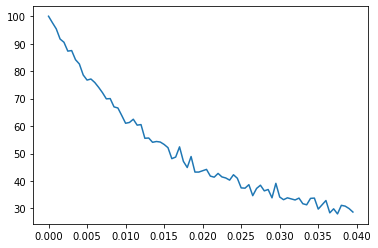

In [100]:
_ = plt.plot(gate1_values, counts_qec_gate1)

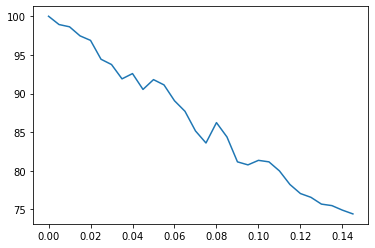

In [101]:
_ = plt.plot(meas_values, counts_qec_meas)

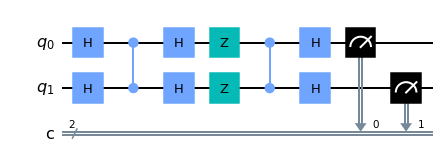

In [102]:
# Grover's circuit without quantum error correction
qreg_q = QuantumRegister(2, 'q')
creg_c = ClassicalRegister(2, 'c')
g_circuit = QuantumCircuit(qreg_q, creg_c)

g_circuit.h(qreg_q[0])
g_circuit.h(qreg_q[1])
g_circuit.cz(qreg_q[0], qreg_q[1])
g_circuit.h(qreg_q[0])
g_circuit.h(qreg_q[1])
g_circuit.z(qreg_q[0])
g_circuit.z(qreg_q[1])
g_circuit.cz(qreg_q[0], qreg_q[1])
g_circuit.h(qreg_q[0])
g_circuit.h(qreg_q[1])
g_circuit.measure(qreg_q[0], creg_c[0])
g_circuit.measure(qreg_q[1], creg_c[1])

g_circuit.draw(output='mpl')

In [146]:
counts_grov_meas = []

for n in noise_p_meas:
    # Create noisy simulator backend
    sim_noise = AerSimulator(noise_model=n)

    # Transpile circuit for noisy basis gates
    circ_tnoise = transpile(s_circuit, sim_noise)

    # Run and get counts
    result_bit_flip = sim_noise.run(circ_tnoise).result()
    counts_bit_flip = result_bit_flip.get_counts(0)

    if '11' in counts_bit_flip.keys():
        counts_grov_meas.append(counts_bit_flip['11']/1024*100)
    else:
        counts_grov_meas.append(0)

print(counts_grov_meas)

[100.0, 99.31640625, 96.6796875, 97.0703125, 95.99609375, 95.41015625, 94.04296875, 93.45703125, 92.87109375, 90.33203125, 90.234375, 89.0625, 88.4765625, 85.44921875, 87.5, 86.1328125, 82.32421875, 82.6171875, 82.6171875, 83.0078125, 81.15234375, 82.6171875, 81.15234375, 80.6640625, 77.83203125, 78.02734375, 78.22265625, 74.4140625, 74.21875, 71.77734375, 73.2421875, 71.58203125, 70.80078125, 71.484375, 68.5546875, 67.48046875, 67.28515625, 65.4296875, 66.796875, 66.015625, 64.6484375, 62.59765625, 60.7421875, 61.5234375, 61.81640625, 58.30078125, 59.66796875, 55.17578125, 57.421875, 57.03125, 57.91015625, 55.37109375, 54.1015625, 55.17578125, 56.640625, 53.7109375, 51.07421875, 51.07421875, 49.70703125, 50.48828125, 50.1953125, 48.046875, 49.21875, 44.62890625, 42.578125, 45.41015625, 44.7265625, 43.5546875, 44.140625, 41.11328125, 44.04296875, 42.3828125, 42.67578125, 39.2578125, 40.234375, 40.4296875, 38.18359375, 38.18359375, 35.9375, 38.671875]


In [147]:
counts_grov_gate1 = []

for n in noise_p_gate1:
    # Create noisy simulator backend
    sim_noise = AerSimulator(noise_model=n)

    # Transpile circuit for noisy basis gates
    circ_tnoise = transpile(s_circuit, sim_noise)

    # Run and get counts
    result_bit_flip = sim_noise.run(circ_tnoise).result()
    counts_bit_flip = result_bit_flip.get_counts(0)

    if '11' in counts_bit_flip.keys():
        counts_grov_gate1.append(counts_bit_flip['11']/1024*100)
    else:
        counts_grov_gate1.append(0)

print(counts_grov_gate1)

[100.0, 97.265625, 94.62890625, 92.7734375, 92.48046875, 90.0390625, 87.3046875, 84.375, 82.03125, 79.78515625, 80.76171875, 75.78125, 74.31640625, 74.609375, 73.92578125, 71.97265625, 69.7265625, 67.28515625, 63.0859375, 66.11328125, 62.5, 60.64453125, 60.64453125, 55.37109375, 59.66796875, 56.15234375, 55.56640625, 55.76171875, 53.90625, 51.953125, 51.7578125, 50.0, 49.0234375, 51.7578125, 47.75390625, 47.94921875, 43.9453125, 47.4609375, 47.265625, 46.2890625, 45.99609375, 44.7265625, 45.1171875, 41.69921875, 41.69921875, 41.30859375, 41.796875, 42.96875, 42.08984375, 40.8203125, 37.3046875, 36.71875, 38.96484375, 36.23046875, 36.1328125, 35.3515625, 34.5703125, 36.5234375, 34.5703125, 33.7890625, 36.03515625, 36.1328125, 35.25390625, 33.0078125, 34.5703125, 35.546875, 32.71484375, 30.56640625, 32.6171875, 32.03125, 31.15234375, 32.51953125, 32.8125, 32.12890625, 28.7109375, 28.3203125, 31.15234375, 32.2265625, 31.34765625, 27.05078125]


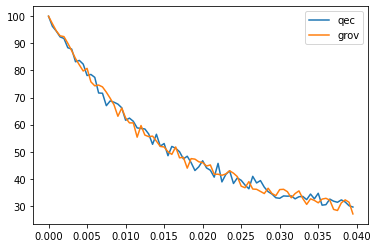

In [151]:
_ = plt.plot(gate1_values, counts_qec_gate1, label='qec')
_ = plt.plot(gate1_values, counts_grov_gate1, label='grov')
_ = plt.xlabel('Noise in noise propability')
_ = plt.ylabel('Accuracy')
_ = plt.title('Accuracy with increasing bit-flip noise')
_ = plt.legend()

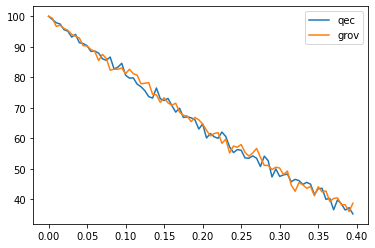

In [152]:
_ = plt.plot(meas_values, counts_qec_meas, label='qec')
_ = plt.plot(meas_values, counts_grov_meas, label = 'grov')
_ = plt.title('Accuracy with increasing bit-flip noise')
_ = plt.legend()

In [136]:
# ADDING THERMAL NOISE TO THE CIRCUIT

# T1 and T2 values for qubits 0-3
T1s = np.random.normal(50e3, 10e3, 4) # Sampled from normal distribution mean 50 microsec
T2s = np.random.normal(70e3, 10e3, 4)  # Sampled from normal distribution mean 50 microsec

# Truncate random T2s <= T1s
T2s = np.array([min(T2s[j], 2 * T1s[j]) for j in range(4)])

thermal_noises = []
times = np.arange(0, 100000, 500)
for t in times:
    # Instruction times (in nanoseconds)
    time_u1 = 0   # virtual gate
    time_u2 = 50  # (single X90 pulse)
    time_u3 = 100 # (two X90 pulses)
    time_cx = 300
    time_reset = t  # 1 microsecond
    time_measure = t # 1 microsecond

    # QuantumError objects
    errors_reset = [thermal_relaxation_error(t1, t2, time_reset)
                    for t1, t2 in zip(T1s, T2s)]
    errors_measure = [thermal_relaxation_error(t1, t2, time_measure)
                    for t1, t2 in zip(T1s, T2s)]
    errors_u1  = [thermal_relaxation_error(t1, t2, time_u1)
                for t1, t2 in zip(T1s, T2s)]
    errors_u2  = [thermal_relaxation_error(t1, t2, time_u2)
                for t1, t2 in zip(T1s, T2s)]
    errors_u3  = [thermal_relaxation_error(t1, t2, time_u3)
                for t1, t2 in zip(T1s, T2s)]
    errors_cx = [[thermal_relaxation_error(t1a, t2a, time_cx).expand(
                thermal_relaxation_error(t1b, t2b, time_cx))
                for t1a, t2a in zip(T1s, T2s)]
                for t1b, t2b in zip(T1s, T2s)]

    # Add errors to noise model
    noise_thermal = NoiseModel()
    for j in range(4):
        noise_thermal.add_quantum_error(errors_reset[j], "reset", [j])
        noise_thermal.add_quantum_error(errors_measure[j], "measure", [j])
        noise_thermal.add_quantum_error(errors_u1[j], "u1", [j])
        noise_thermal.add_quantum_error(errors_u2[j], "u2", [j])
        noise_thermal.add_quantum_error(errors_u3[j], "u3", [j])
        for k in range(4):
            noise_thermal.add_quantum_error(errors_cx[j][k], "cx", [j, k])
    
    thermal_noises.append(noise_thermal)



In [153]:
counts_grov_thermal = []

for noise in thermal_noises:
    # Run the noisy simulation
    sim_thermal = AerSimulator(noise_model=noise)

    # Transpile circuit for noisy basis gates
    circ_tthermal = transpile(g_circuit, sim_thermal)

    # Run and get counts
    result_thermal = sim_thermal.run(circ_tthermal).result()
    counts_thermal = result_thermal.get_counts(0)

    if '11' in counts_thermal.keys():
        counts_grov_thermal.append(counts_thermal['11']/1024*100)
    else:
        counts_grov_thermal.append(0)

print(counts_grov_thermal)


[98.53515625, 96.2890625, 95.1171875, 93.5546875, 91.40625, 90.13671875, 88.96484375, 86.42578125, 84.765625, 84.9609375, 84.1796875, 80.078125, 79.296875, 81.4453125, 76.7578125, 76.07421875, 73.2421875, 72.265625, 72.265625, 71.58203125, 71.6796875, 70.01953125, 65.0390625, 68.45703125, 66.40625, 62.79296875, 64.94140625, 60.15625, 60.9375, 63.8671875, 60.15625, 57.6171875, 57.12890625, 59.27734375, 59.27734375, 54.58984375, 52.44140625, 52.44140625, 53.515625, 50.1953125, 53.22265625, 47.65625, 51.7578125, 45.3125, 45.703125, 46.58203125, 48.046875, 41.11328125, 43.1640625, 40.52734375, 40.625, 41.30859375, 40.91796875, 36.42578125, 41.015625, 42.578125, 36.328125, 38.4765625, 38.0859375, 36.03515625, 35.25390625, 38.0859375, 37.5, 33.69140625, 33.30078125, 33.59375, 30.95703125, 31.34765625, 32.8125, 31.4453125, 29.6875, 30.2734375, 29.98046875, 28.02734375, 29.58984375, 27.83203125, 26.3671875, 27.63671875, 25.5859375, 24.609375, 24.8046875, 26.66015625, 23.4375, 22.36328125, 23.8

In [154]:
counts_qec_thermal = []

for noise in thermal_noises:
    # Run the noisy simulation
    sim_thermal = AerSimulator(noise_model=noise)

    # Transpile circuit for noisy basis gates
    circ_tthermal = transpile(s_circuit, sim_thermal)

    # Run and get counts
    result_thermal = sim_thermal.run(circ_tthermal).result()
    counts_thermal = result_thermal.get_counts(0)

    if '11' in counts_thermal.keys():
        counts_qec_thermal.append(counts_thermal['11']/1024*100)
    else:
        counts_qec_thermal.append(0)

print(counts_qec_thermal)


[94.53125, 92.96875, 90.4296875, 87.01171875, 86.328125, 84.1796875, 82.32421875, 81.8359375, 82.51953125, 78.80859375, 80.2734375, 75.9765625, 74.0234375, 72.94921875, 70.703125, 69.7265625, 70.5078125, 65.33203125, 67.08984375, 62.3046875, 62.5, 60.546875, 62.79296875, 58.7890625, 59.08203125, 56.15234375, 55.37109375, 54.78515625, 52.44140625, 50.0, 48.92578125, 49.21875, 51.5625, 45.5078125, 46.38671875, 47.4609375, 44.921875, 44.921875, 42.67578125, 41.796875, 44.140625, 40.234375, 41.50390625, 38.28125, 38.8671875, 38.0859375, 39.2578125, 38.28125, 38.671875, 34.86328125, 36.03515625, 33.0078125, 32.12890625, 35.64453125, 32.6171875, 29.6875, 30.6640625, 31.73828125, 32.2265625, 28.02734375, 27.5390625, 27.83203125, 27.83203125, 27.05078125, 25.1953125, 22.94921875, 23.92578125, 25.0, 24.51171875, 21.484375, 22.36328125, 24.0234375, 23.73046875, 23.046875, 20.99609375, 20.1171875, 21.09375, 19.921875, 19.82421875, 19.04296875, 19.62890625, 21.77734375, 14.453125, 17.87109375, 19.

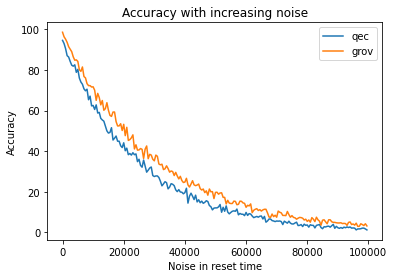

In [155]:
_ = plt.plot(times, counts_qec_thermal, label = 'qec')
_ = plt.plot(times, counts_grov_thermal, label = 'grov')
_ = plt.title('Accuracy with increasing thermal noise')
_ = plt.xlabel('Noise in reset time')
_ = plt.ylabel('Accuracy')
_ = plt.legend()

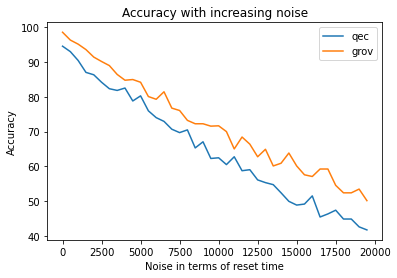

In [156]:
_ = plt.plot(times[0:40], counts_qec_thermal[0:40], label = 'qec')
_ = plt.plot(times[0:40], counts_grov_thermal[0:40], label = 'grov')
_ = plt.title('Accuracy with increasing thermal noise')
_ = plt.xlabel('Noise in terms of reset time')
_ = plt.ylabel('Accuracy')
_ = plt.legend()